<a href="https://colab.research.google.com/github/SergeySmalkov/Strategies_Sandbox/blob/main/TWAP%20detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from IPython.core.display import display, HTML
from scipy import signal
from numba import jit

In [2]:
# from google.colab import files
# uploaded = files.upload()

In [3]:
import os
os.listdir()

['.config',
 'binance',
 'trades_Huobi',
 'trades_Okex',
 'trades_Binance',
 'sample_data']

In [4]:
binance_trades = pd.read_pickle('trades_Binance')
okex_trades = pd.read_pickle('trades_Okex')
huobi_trades = pd.read_pickle('trades_Huobi')
trades = pd.concat([binance_trades, okex_trades, huobi_trades], axis=0).sort_values(by='receive_timestamp').set_index('receive_timestamp', drop=False)

<Axes: xlabel='receive_timestamp'>

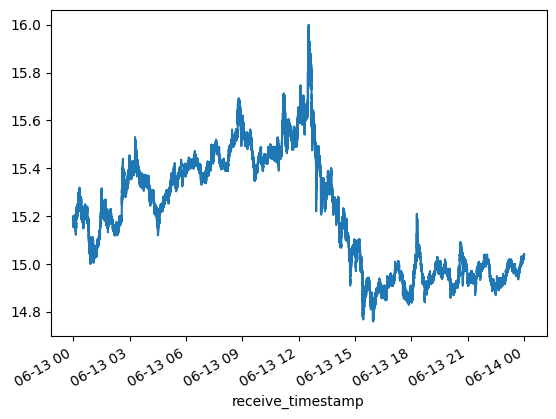

In [5]:
trades["price"].plot()

In [6]:
merged_df = trades[trades["maker_side"] == "Ask"]

if the time between rows is less than parameter (let's say 0.03ms) then delete two rows and create one with the weighted by size time that and in sum column it will be sum of these two rows - then proceed to the further rows using the previous row as usual (it might be merged again with the next if satisfies condition)

In [7]:
@jit(nopython=True)
def merge_rows(time, size, time_threshold_sec):
    i = 0
    merged_time = []
    merged_size = []
    while i < len(time) - 1:
        time_diff = time[i+1] - time[i]
        if time_diff <= time_threshold_sec:
            total_size = size[i] + size[i+1]
            weighted_time = ((time[i] * size[i]) + (time[i+1] * size[i+1])) / total_size
            merged_time.append(weighted_time)
            merged_size.append(total_size)
            i += 2
        else:
            merged_time.append(time[i])
            merged_size.append(size[i])
            i += 1
    if i == len(time) - 1:
        merged_time.append(time[i])
        merged_size.append(size[i])

    return np.array(merged_time), np.array(merged_size)


In [8]:
# Convert DataFrame to Numpy arrays
time = merged_df['receive_timestamp'].values.astype(float)
size = merged_df['amount'].values

#150ms
time_threshold_sec = 150000000
merged_time, merged_size = merge_rows(time, size, time_threshold_sec)

# Convert the result back to DataFrame
df_merged = pd.DataFrame({'timestamp': pd.to_datetime(merged_time), 'sum': merged_size})

tolerance = 0.00001
if abs(merged_df["amount"].sum() - df_merged["sum"].sum()) > tolerance:
    raise AssertionError("Sums are not approximately equal.")
df_merged

,timestamp,sum
0,2023-06-13 00:00:01.196000000,7.030000
1,2023-06-13 00:00:04.691499776,1.660000
2,2023-06-13 00:00:04.839403008,0.670000
3,2023-06-13 00:00:05.624380416,9.780000
4,2023-06-13 00:00:05.661580544,4.721033
...,...,...
127399,2023-06-13 23:59:53.731000064,0.440000
127400,2023-06-13 23:59:54.640000000,0.273863
127401,2023-06-13 23:59:55.756999936,8.540000
127402,2023-06-13 23:59:56.936000000,0.013058


In [9]:
N = 5  # Number of parts
# The qcut() function discretizes the variable into equal-sized buckets based on rank or
# based on sample quantiles.
# Create buckets based on quantiles and create a new column 'bucket'
buckets = pd.qcut(df_merged['sum'], N)
print(buckets.cat.categories.values)

df_merged['bucket'] = pd.qcut(df_merged['sum'], N, labels=False)

# List to hold dataframes
df_list = []

for i in range(N):
    df_part = df_merged[df_merged['bucket'] == i]
    df_list.append(df_part.drop(['bucket'], axis=1).reset_index(drop=True))
df_list[0]

<IntervalArray>
[(-0.000999, 0.98], (0.98, 1.55], (1.55, 3.3], (3.3, 24.02], (24.02, 40344.19]]
Length: 5, dtype: interval[float64, right]


,timestamp,sum
0,2023-06-13 00:00:04.839403008,0.670000
1,2023-06-13 00:00:36.348000000,0.132844
2,2023-06-13 00:00:36.958000128,0.099459
3,2023-06-13 00:00:38.088999936,0.198521
4,2023-06-13 00:00:57.998000128,0.760000
...,...,...
26176,2023-06-13 23:59:49.816999936,0.840000
26177,2023-06-13 23:59:49.838000128,0.027205
26178,2023-06-13 23:59:53.731000064,0.440000
26179,2023-06-13 23:59:54.640000000,0.273863


In [10]:
from collections import defaultdict
import bisect


# Define the time window in minutes
T = 1
# Initialize an empty dictionary to hold dataframes

# epsilon = 0.2
# hashmaps = []
# # for df in df_list:
# df = df_list[1][0:15000]

epsilon = 0.2
hashmaps = []
for df in df_list:
    # df = df_list[4]
    hashmap = defaultdict(pd.DataFrame)
    # Iterate over the dataframe
    for i in range(len(df)):
        # Get the timestamp of the current row
        timestamp_i = df.loc[i, 'timestamp']

        # Initialize lists to hold column data
        time_distance = []
        ID = []
        TWAP = []
        SIZES = []
        TIMES = []

        # Iterate backwards over the dataframe from the current row within the time window
        j = i - 1

        while j >= 0 and (timestamp_i - df.loc[j, 'timestamp']).total_seconds() <= T*60:

            # Calculate the time difference
            time_diff = (timestamp_i - df.loc[j, 'timestamp']).total_seconds()

            # Add the calculated data to the lists
            time_distance.append(time_diff)
            ID.append(j)
            SIZES.append(df.loc[i, 'sum'])
            TIMES.append(df.loc[i, 'timestamp'])
            df_j = hashmap[j]

            if not df_j.empty:
                array = df_j['time_distance'].tolist()
                idx = bisect.bisect_left(array, time_diff - epsilon)

                k = idx
                MAX_TWAP = 0
                while k < len(array) and abs(array[k] - time_diff) <= epsilon:
                    MAX_TWAP = max(MAX_TWAP, df_j.iloc[k]['TWAP'])
                    k += 1

                if k != idx:
                    TWAP.append(MAX_TWAP + 1)
                else:
                    TWAP.append(int(0))
            else:
                TWAP.append(int(0))

            j -= 1

            # Create a new dataframe from the lists and add it to the hashmap
        df_i = pd.DataFrame({'time_distance': time_distance, 'ID': ID,
                              'TWAP': TWAP, "SIZES": SIZES, "TIMES":TIMES})
        hashmap[i] = df_i
    hashmaps.append(hashmap.copy())

In [11]:
# hashmaps
slice_min_threshhold = 5

counter_twap = [[] for x in range(N)]
for j in range(N):
# for j in range(1):
    for i in range(len(hashmaps[j])):
        counter_twap[j].append(len(hashmaps[j][i][hashmaps[j][i]["TWAP"] >= slice_min_threshhold]))

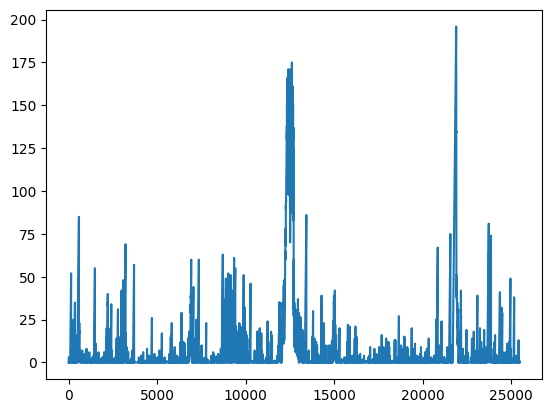

In [33]:
from matplotlib import pyplot as plt
plt.plot(counter_twap[4], drawstyle='steps-post')

In [26]:
output = pd.DataFrame(columns = ["time_distance", "ID", "TWAP", "SIZES", "TIMES"])
table = hashmaps[2]
idx = 0
max_twap = 0
for id, tb in enumerate(table.values()):
    # print(tb["TWAP"].max())
    # print(max_twap)
    if(tb["TWAP"].max() > max_twap):
        idx = id
        max_twap = max(tb["TWAP"].max(), max_twap)
print(max_twap)
print(idx)

44
16103


In [27]:
order_idx = idx
idx = table[order_idx]["TWAP"].idxmax()
row = table[order_idx].iloc[idx]

output.loc[len(output)] = row
TWAP_COUNTER = row["TWAP"]

while TWAP_COUNTER > 0:
    TWAP_COUNTER -= 1
    temp_table = table[row["ID"]]
    temp_table = temp_table[temp_table["TWAP"] == TWAP_COUNTER]
    temp_table = temp_table[temp_table["time_distance"] <= row["time_distance"] + epsilon]
    temp_table = temp_table[temp_table["time_distance"] >= row["time_distance"] - epsilon]
    row = temp_table.iloc[0]
    output.loc[len(output)] = row

In [28]:
output

,time_distance,ID,TWAP,SIZES,TIMES
0,0.049329,16102,44,2.79,2023-06-13 12:56:39.022329856
1,0.004,16101,43,2.08,2023-06-13 12:56:38.972999936
2,0.008,16100,42,2.08,2023-06-13 12:56:38.968999936
3,0.002999,16099,41,1.62,2023-06-13 12:56:38.960999936
4,0.006,16098,40,1.56,2023-06-13 12:56:38.958000128
5,0.003598,16097,39,2.27,2023-06-13 12:56:38.952000000
6,0.000901,16096,38,1.62,2023-06-13 12:56:38.948401152
7,0.0035,16095,37,1.94,2023-06-13 12:56:38.947500032
8,0.001588,16094,36,1.56,2023-06-13 12:56:38.944000000
9,0.000411,16093,35,1.58,2023-06-13 12:56:38.942411520


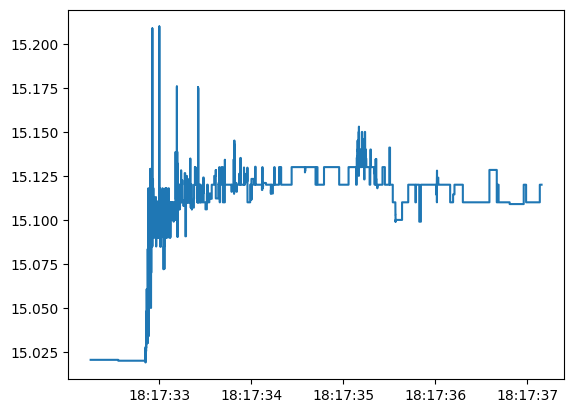

In [36]:
# plt.plot(trades[(trades["receive_timestamp"] >= "2023-06-13 12:55:37.709000192") &
#  (trades["receive_timestamp"] <= "2023-06-13 12:57:43.979908864")]["price"], drawstyle='steps-post')

# plt.plot(trades[(trades["receive_timestamp"] >= "2023-06-13 12:56:37.579908864") &
#  (trades["receive_timestamp"] <= "2023-06-13 12:56:45.079908864")]["price"], drawstyle='steps-post')

# plt.plot(trades[(trades["receive_timestamp"] >= "2023-06-13 12:30:00.492964864") &
#  (trades["receive_timestamp"] <= "2023-06-13 12:30:31.72964864")]["price"], drawstyle='steps-post')

plt.plot(trades[(trades["receive_timestamp"] >= "2023-06-13 18:17:31.849999872") &
 (trades["receive_timestamp"] <= "2023-06-13 18:17:37.209999872")]["price"], drawstyle='steps-post')